In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
npz = np.load('preprocesseddata.npz')
x = npz['x']
y = npz['y']

In [3]:
print(x.shape, y.shape)

(20631, 16) (20631,)


In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.8, random_state=8)
print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

(16504, 16) (16504,) (4127, 16) (4127,)


In [5]:
# from sklearn.linear_model import LinearRegression
# reg = LinearRegression()
# reg.fit(xtrain, ytrain)
# print(reg.score(xtrain, ytrain))

In [6]:
import lightgbm as lgbm

In [13]:
lgbmclass = lgbm.LGBMClassifier(learning_rate = 0.01, n_estimators=5000, num_leaves=100,
                                objective='binary', metric='auc', random_state=50, n_jobs=-1)
lgbmclass.fit(xtrain,ytrain)

LGBMClassifier(learning_rate=0.01, metric='auc', n_estimators=5000,
               num_leaves=100, objective='binary', random_state=50)

In [16]:
ypredlgbm = lgbmclass.predict(xtest)

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

In [18]:
print('Acc score ',accuracy_score(ytest, ypredlgbm))
print('ROC AUC score ', roc_auc_score(ytest, ypredlgbm))
print('Precision score ',precision_score(ytest, ypredlgbm))
print('Recall score ', recall_score(ytest, ypredlgbm))
print('F1 score ', f1_score(ytest, ypredlgbm))

Acc score  0.9578386236976012
ROC AUC score  0.8970971780769162
Precision score  0.902135231316726
Recall score  0.8099041533546326
F1 score  0.8535353535353536


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
xcolumns = ['op1', 'op2', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
       'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor17', 'sensor20', 'sensor21']

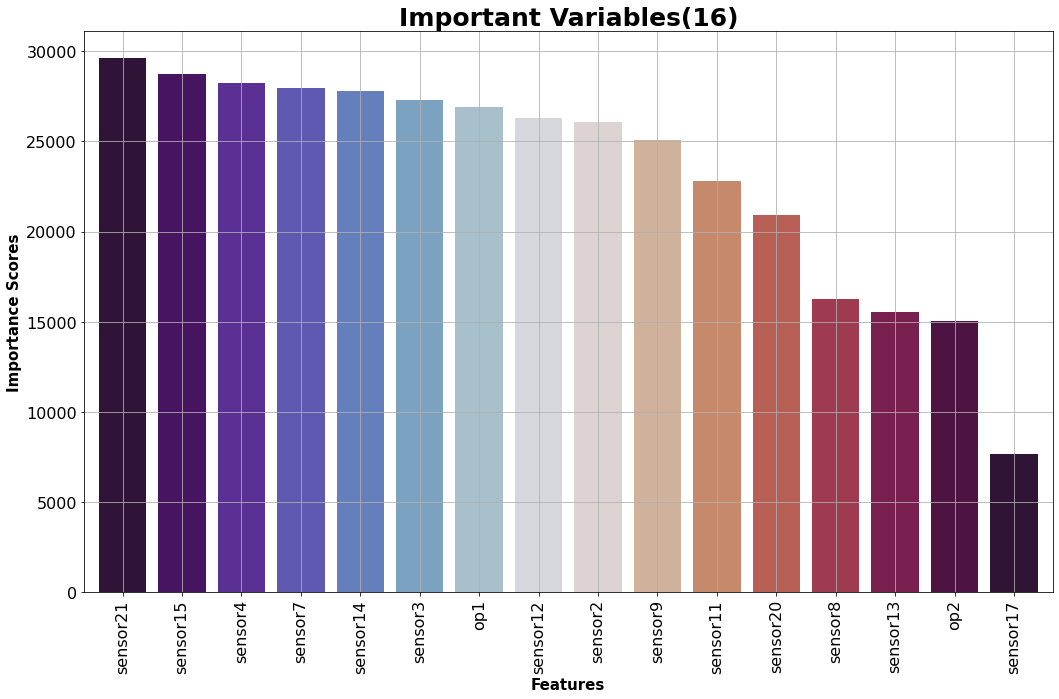

In [29]:
colors = [plt.cm.twilight_shifted(i/float(len(xcolumns)-1)) for i in range(len(xcolumns))]
columnsxtrain=xcolumns
xtrain=pd.DataFrame(xtrain)
xtrain.set_axis(columnsxtrain, axis=1, inplace=True)
feat_importances = pd.Series(lgbmclass.feature_importances_, index=xtrain.columns)
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 16})
plt.title('Important Variables(16)',color='black',fontweight='bold',size=25)
feat_importances.nlargest(16).plot(kind='bar', color=colors, width=0.8, align='center')
plt.ylabel('Importance Scores',color='black',fontweight='bold',size=15)
plt.xlabel('Features',color='black',fontweight='bold',size=15)
plt.tight_layout()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Variables')

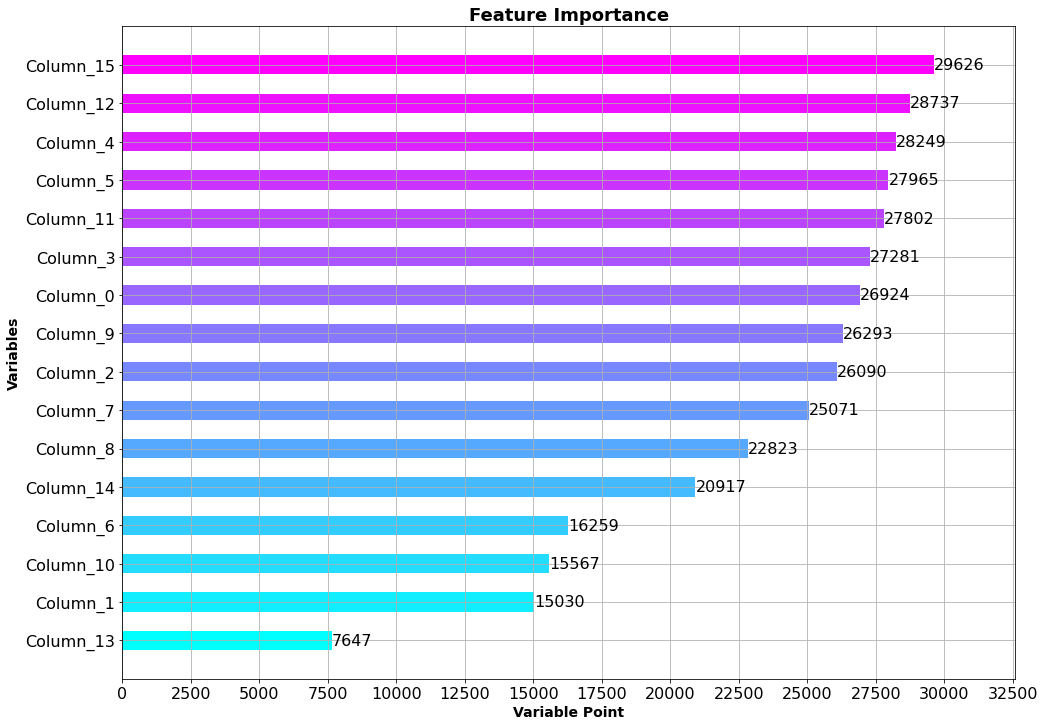

In [30]:
colors = [plt.cm.cool(i/float(len(xcolumns)-1)) for i in range(len(xcolumns))]
ax = lgbm.plot_importance(lgbmclass, max_num_features=16,figsize=(16,12),height=0.5,color=colors)
ax.set_title('Feature Importance',color='black',fontweight='bold',size=18)
ax.set_xlabel('Variable Point',color='black',fontweight='bold',size=14)
ax.set_xticks(np.arange(0,32501,2500))
ax.set_ylabel('Variables',color='black',fontweight='bold',size=14)

In [32]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import xgboost as xgb
stkf = StratifiedKFold(n_splits=5)
xgbclass = xgb.XGBClassifier(n_estimators=725, n_jobs=-1)
params={
    'learning_rate': np.arange(0.01, 0.11, 0.025),
    'max_depth': np.arange(1, 10, 1),
    'min_child_weight': np.arange(1, 10, 1), 
    'subsample': np.arange( 0.7, 1, 0.05), 
    'gamma': np.arange(0.5, 1, 0.1), 
    'colsample_bytree': np.arange( 0.1, 1, 0.05), 
    'scale_pos_weight': np.arange( 20, 200, 10)
}
rscvclass = RandomizedSearchCV(xgbclass, param_distributions=params, cv=stkf, n_jobs=-1)
rscvclass.fit(xtrain, ytrain)
ypredxgb = rscvclass.predict(xtest)
print('Best Params: \n', rscvclass.best_params_)
print('XGB Accuracy Score: ', accuracy_score(ytest, ypredxgb))

C:\Users\DELL\AppData\Local\conda\conda\envs\py3-TF2.0\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:18:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params: 
 {'subsample': 1.0000000000000002, 'scale_pos_weight': 40, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.085, 'gamma': 0.8999999999999999, 'colsample_bytree': 0.9000000000000002}
XGB Accuracy Score:  0.9508117276472013


<AxesSubplot:>

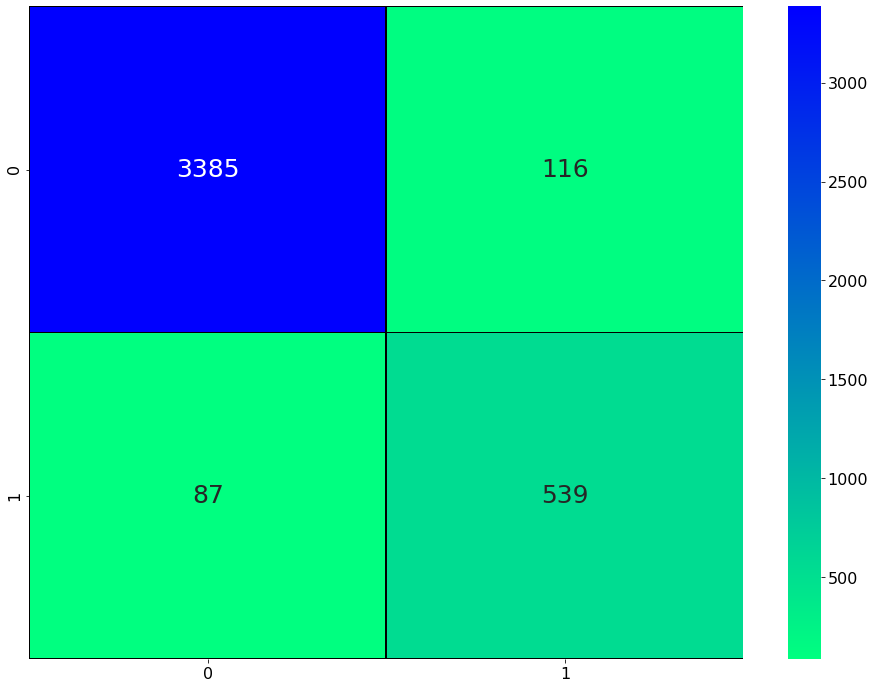

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest, ypredxgb, labels=None, sample_weight=None)
plt.figure(figsize=(16,12))
sns.heatmap(cm,annot=True,annot_kws={"size": 25},linewidths=0.7,linecolor="black",cmap="winter_r",fmt="d")